<img src="images/seattlewaterfront.jpg">

# King County House Sales Analysis
Author: Jennifer Ha
***

## Overview
This analysis project explores trends in film business to provide Microsoft with actionable recommendations as they want to enter this business as well. we will review data sets from TheNumbers.com and IMDb to determine when Microsoft should release a movie, which types of genres to consider, and whom to recruit. The methodology includes filtering, and joining and visualizing data sets to show different trends in ROI. The result shows higher ROI when Mystery, Horror, and Animation movies are released in May-July, and November-December. I recommend Microsoft to partner with lists of top 10 actors and directors in those genres, and release movies during the summer (May-July) or holiday season (Nov-Dec).

## Business Problem
Microsoft sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies.

In order to assist the stakeholders at Microsoft to make data-driven decisions for their new business, we will be reviewing and analyzing datasets to provide a viable and profitable business option. The findings and recommendations will help the stakeholders with better understanding of the movie industry, to decide when to release their movies and who to work with to drive a successful outcome.

## Data

### Data Preparation & Clean Up

In [1]:
#import all libraries & packages
import numpy as np
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt
import matplotlib.colors as pltcol
import seaborn as sns
import math

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools.eval_measures as ev
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score
from scipy.special import boxcox, inv_boxcox


import scipy.stats as stats
from statsmodels.formula.api import ols

%matplotlib inline

#importing my personal functions 
from functions import metrics, result_plot

#remove scientific notation
pd.options.display.float_format = '{:,.5f}'.format

#display all the columns without truncation
pd.set_option('display.max_columns', None)

#import data into a dataframe and preview 
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,"221,900.00000",3,1.00000,1180,5650,1.00000,nan,0.00000,3,7,1180,0.0,1955,0.00000,98178,47.51120,-122.25700,1340,5650
1,6414100192,12/9/2014,"538,000.00000",3,2.25000,2570,7242,2.00000,0.00000,0.00000,3,7,2170,400.0,1951,"1,991.00000",98125,47.72100,-122.31900,1690,7639
2,5631500400,2/25/2015,"180,000.00000",2,1.00000,770,10000,1.00000,0.00000,0.00000,3,6,770,0.0,1933,nan,98028,47.73790,-122.23300,2720,8062
3,2487200875,12/9/2014,"604,000.00000",4,3.00000,1960,5000,1.00000,0.00000,0.00000,5,7,1050,910.0,1965,0.00000,98136,47.52080,-122.39300,1360,5000
4,1954400510,2/18/2015,"510,000.00000",3,2.00000,1680,8080,1.00000,0.00000,0.00000,3,8,1680,0.0,1987,0.00000,98074,47.61680,-122.04500,1800,7503


In [2]:
#get summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

From the above summary, we see that 'date', 'yr_built', 'yr_renovated', and 'sqft_basement' have wrong data type. 'waterfront', 'view', and 'yr_renovated' also have null values that we need to take care of. Let's check for duplicates first and we will clean up the data step by step.

### Check for Duplicates

In [3]:
#check for duplicates in 'id' which should work as index
df.id.duplicated().sum()

177

In [4]:
#create a separate table to examine the duplicates
df_id_duplicates = df[df.duplicated('id')]

In [5]:
df_id_duplicates

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
94,6021501535,12/23/2014,"700,000.00000",3,1.50000,1580,5000,1.00000,0.00000,0.00000,3,8,1290,290.0,1939,0.00000,98117,47.68700,-122.38600,1570,4500
314,4139480200,12/9/2014,"1,400,000.00000",4,3.25000,4290,12103,1.00000,0.00000,3.00000,3,11,2690,1600.0,1997,0.00000,98006,47.55030,-122.10200,3860,11244
325,7520000520,3/11/2015,"240,500.00000",2,1.00000,1240,12092,1.00000,0.00000,0.00000,3,6,960,280.0,1922,"1,984.00000",98146,47.49570,-122.35200,1820,7460
346,3969300030,12/29/2014,"239,900.00000",4,1.00000,1000,7134,1.00000,0.00000,0.00000,3,6,1000,0.0,1943,nan,98178,47.48970,-122.24000,1020,7138
372,2231500030,3/24/2015,"530,000.00000",4,2.25000,2180,10754,1.00000,0.00000,0.00000,5,7,1100,1080.0,1954,0.00000,98133,47.77110,-122.34100,1810,6929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20165,7853400250,2/19/2015,"645,000.00000",4,3.50000,2910,5260,2.00000,0.00000,0.00000,3,9,2910,0.0,2012,0.00000,98065,47.51680,-121.88300,2910,5260
20597,2724049222,12/1/2014,"220,000.00000",2,2.50000,1000,1092,2.00000,0.00000,0.00000,3,7,990,10.0,2004,0.00000,98118,47.54190,-122.27100,1330,1466
20654,8564860270,3/30/2015,"502,000.00000",4,2.50000,2680,5539,2.00000,nan,0.00000,3,8,2680,0.0,2013,0.00000,98045,47.47590,-121.73400,2680,5992
20764,6300000226,5/4/2015,"380,000.00000",4,1.00000,1200,2171,1.50000,0.00000,0.00000,3,7,1200,0.0,1933,0.00000,98133,47.70760,-122.34200,1130,1598


In [6]:
#spot check data
df.loc[df['id'] == 6021501535]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
93,6021501535,7/25/2014,"430,000.00000",3,1.50000,1580,5000,1.00000,0.00000,0.00000,3,8,1290,290.0,1939,0.00000,98117,47.68700,-122.38600,1570,4500
94,6021501535,12/23/2014,"700,000.00000",3,1.50000,1580,5000,1.00000,0.00000,0.00000,3,8,1290,290.0,1939,0.00000,98117,47.68700,-122.38600,1570,4500


In [7]:
#spot check data
df.loc[df['id'] == 3969300030]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
345,3969300030,7/23/2014,"165,000.00000",4,1.00000,1000,7134,1.00000,0.00000,0.00000,3,6,1000,0.0,1943,0.00000,98178,47.48970,-122.24000,1020,7138
346,3969300030,12/29/2014,"239,900.00000",4,1.00000,1000,7134,1.00000,0.00000,0.00000,3,6,1000,0.0,1943,nan,98178,47.48970,-122.24000,1020,7138


In [8]:
#spot check data
df.loc[df['id'] == 6300000226]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
20763,6300000226,6/26/2014,"240,000.00000",4,1.00000,1200,2171,1.50000,0.00000,0.00000,3,7,1200,0.0,1933,0.00000,98133,47.70760,-122.34200,1130,1598
20764,6300000226,5/4/2015,"380,000.00000",4,1.00000,1200,2171,1.50000,0.00000,0.00000,3,7,1200,0.0,1933,0.00000,98133,47.70760,-122.34200,1130,1598


It appears that houses with multiple transactions were recorded with the same id for each transaction. I'm only going to keep the latest transaction.

In [9]:
#drop the older data
df.drop_duplicates(subset= 'id', keep= 'last', inplace= True)

In [10]:
#check if the duplicates are removed
df.id.duplicated().sum()

0

### Datetime - date

In [11]:
#convert date
df['date'] = pd.to_datetime(df['date'])

In [12]:
df['month_sold'] = df.date.dt.month
df['year_sold'] = df.date.dt.year
df.drop(['date'], axis= 1, inplace= True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21420 non-null  int64  
 1   price          21420 non-null  float64
 2   bedrooms       21420 non-null  int64  
 3   bathrooms      21420 non-null  float64
 4   sqft_living    21420 non-null  int64  
 5   sqft_lot       21420 non-null  int64  
 6   floors         21420 non-null  float64
 7   waterfront     19067 non-null  float64
 8   view           21357 non-null  float64
 9   condition      21420 non-null  int64  
 10  grade          21420 non-null  int64  
 11  sqft_above     21420 non-null  int64  
 12  sqft_basement  21420 non-null  object 
 13  yr_built       21420 non-null  int64  
 14  yr_renovated   17607 non-null  float64
 15  zipcode        21420 non-null  int64  
 16  lat            21420 non-null  float64
 17  long           21420 non-null  float64
 18  sqft_l

### Integer - sqft_basement

In [14]:
#check why sqft_basement is an object and not an integer
df.sqft_basement.value_counts()

0.0       12716
?           452
600.0       216
500.0       206
700.0       206
          ...  
946.0         1
1930.0        1
2390.0        1
2730.0        1
2400.0        1
Name: sqft_basement, Length: 304, dtype: int64

In [15]:
#replace '?' in sqft_basement to 0 since they are unidentifiable
df['sqft_basement'] = df['sqft_basement'].replace('?', '0.0')

df.sqft_basement.value_counts()

0.0       13168
600.0       216
700.0       206
500.0       206
800.0       201
          ...  
946.0         1
1930.0        1
2390.0        1
2730.0        1
2400.0        1
Name: sqft_basement, Length: 303, dtype: int64

In [16]:
# change data type of basement to float instead of object
df['sqft_basement'] = df.sqft_basement.astype('float')

### Null Values
We have identified that 'waterfront', 'view', and 'yr_renovated' columns have missing values. Let's examine each of them and determine how we will proceed.

In [17]:
#check 'waterfront'
df.waterfront.value_counts(normalize = True)

0.00000   0.99234
1.00000   0.00766
Name: waterfront, dtype: float64

In [18]:
#check 'view'
df.view.value_counts(normalize = True)

0.00000   0.90148
2.00000   0.04476
3.00000   0.02365
1.00000   0.01540
4.00000   0.01470
Name: view, dtype: float64

In [19]:
#check 'yr_renovated'
df.yr_renovated.value_counts(normalize = True)

0.00000       0.95797
2,014.00000   0.00415
2,003.00000   0.00176
2,013.00000   0.00176
2,007.00000   0.00170
                ...  
1,934.00000   0.00006
1,971.00000   0.00006
1,954.00000   0.00006
1,950.00000   0.00006
1,944.00000   0.00006
Name: yr_renovated, Length: 70, dtype: float64

Above analysis shows that:
1. 99.2% of houses in the dataseet are not near the Seattle waterfront.
2. 90.1% of houses do not have a view. 
3. 95.8% of houses have not been renovated since it was built.

While having such large amount of null values can be problematic, it makes sense in this scenario.Therefore, we will simply replace those null values with zeros. 

In [20]:
#replace null values with zeros
df.fillna(0, inplace= True)

Lastly, let's re-set the index.

In [21]:
#re-set index
df.reset_index(inplace = True, drop = True)

#double-check data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21420 entries, 0 to 21419
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21420 non-null  int64  
 1   price          21420 non-null  float64
 2   bedrooms       21420 non-null  int64  
 3   bathrooms      21420 non-null  float64
 4   sqft_living    21420 non-null  int64  
 5   sqft_lot       21420 non-null  int64  
 6   floors         21420 non-null  float64
 7   waterfront     21420 non-null  float64
 8   view           21420 non-null  float64
 9   condition      21420 non-null  int64  
 10  grade          21420 non-null  int64  
 11  sqft_above     21420 non-null  int64  
 12  sqft_basement  21420 non-null  float64
 13  yr_built       21420 non-null  int64  
 14  yr_renovated   21420 non-null  float64
 15  zipcode        21420 non-null  int64  
 16  lat            21420 non-null  float64
 17  long           21420 non-null  float64
 18  sqft_l

### Baseline Model
Now that we cleaned up the data, let's take a look at a baseline model.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     2393.
Date:                Sun, 27 Jun 2021   Prob (F-statistic):               0.00
Time:                        00:33:42   Log-Likelihood:            -2.9194e+05
No. Observations:               21420   AIC:                         5.839e+05
Df Residuals:                   21398   BIC:                         5.841e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -6.713e+07   9.98e+06     -6.725      0.000   -8.67e+07   -4.76e+07
id            -1.407e-06   4.84e-07     -2.907      0.004   -2.36e-06   -4.58e-07
bedrooms       -3.61e+04   1908.859    -18.914      0.000   -3.98e+04   -3.24e+04
bathrooms      4.237e+04   3272.478     12.947      0.000     3.6e+04    4.88e+04
sqft_living     103.9252     18.086      5.746      0.000      68.476     139.375
sqft_lot          0.1151      0.048      2.399      0.016       0.021       0.209
floors         7444.9135   3604.789      2.065      0.039     379.257    1.45e+04
waterfront     6.181e+05   1.81e+04     34.112      0.000    5.83e+05    6.54e+05
view           5.299e+04   2126.843     24.916      0.000    4.88e+04    5.72e+04
condition      2.792e+04   2363.147     11.814      0.000    2.33e+04    3.26e+04
grade          9.741e+04   2166.854     44.955      0.000    9.32e+04    1.02e+05
sqft_above       76.8246     18.076      4.250      0.000      41.393     112.256
sqft_basement    47.2570     17.915      2.638      0.008      12.143      82.371
yr_built      -2652.4748     72.108    -36.785      0.000   -2793.812   -2511.138
yr_renovated     24.4140      3.985      6.126      0.000      16.602      32.226
zipcode        -583.4840     33.102    -17.627      0.000    -648.367    -518.601
lat            6.039e+05   1.08e+04     56.104      0.000    5.83e+05    6.25e+05
long          -2.152e+05   1.32e+04    -16.296      0.000   -2.41e+05   -1.89e+05
sqft_living15    21.0448      3.455      6.091      0.000      14.272      27.817
sqft_lot15       -0.3994      0.073     -5.435      0.000      -0.543      -0.255
month_sold     1235.1060    708.971      1.742      0.082    -154.530    2624.742
year_sold      3.667e+04   4727.812      7.755      0.000    2.74e+04    4.59e+04
==============================================================================
Omnibus:                    18272.897   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1867102.704
Skew:                           3.582   Prob(JB):                         0.00
Kurtosis:                      48.174   Cond. No.                     3.93e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.93e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fb46e03e6d0>,
 <Figure size 1008x432 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='Theoretical Quantiles', ylabel='Sample Quantiles'>,
        <AxesSubplot:title={'center':'Homoscedasticity of Residuals'}, xlabel='Predicted Price', ylabel='Residuals'>],
       dtype=object))

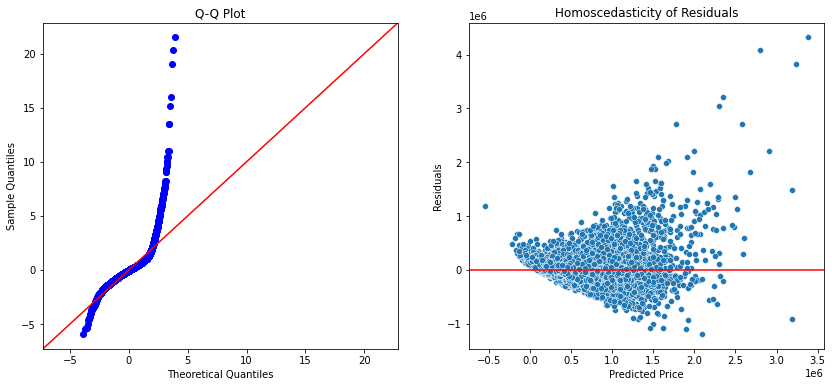

In [22]:
result_plot(df)

### Exploratory Data Analysis (EDA)

## Model 1

## Model 2

## Model 3

## Conclusions
This analysis leads to three recommendations for creating movies :

**1. Release movies in May, June, July, November, or December.** Our analysis shows that summertime and holiday seasons are the best time of year to release a movie. If Microsoft wants to release a movie across the world simultaneously, I recommend launching a movie in June or July. If different timeline can be applied, release a movie in the States in May first, then internationally in June.

**2. Produce a movie in Mystery, Horror, Animation genres.** Microsoft has the capability to run movie business in many countries as it has many locations worldwide. Therefore, I recommend producing a movie in Mystery, Horror, and Animation to target audience globally.

**3. Recruit people with proven stats.** I provided lists of top 10 actors and directors in top 3 genres that generated the most profit. Microsoft should contact these individuals and try to recruit them to enter this competitive movie industry

## Next Steps
Further analyses could lead to additional insights:
* **ROI Trend in Popular Genres**: while we have identified which top 3 genres have generated the most profit, such analysis can provide whether the business is continuously growing in those genres over time.
* **Ideal Budget Range**: This modeling could predict the ideal production budget for the movies that Microsoft wants to produce.